In [6]:
import numpy as np
from icecream import ic
from tqdm import tqdm


### Defining 2 functions for testing (we should use the one the professor provided in the final code)

In [7]:
#true functions for 2 and 3 variables
def true_f(x: np.ndarray) -> np.ndarray:
    return x[0] + np.sin(x[1]) / 5
def true_f2(x: np.ndarray) -> np.ndarray:
    return x[0] + np.sin(x[1]) / 5 + x[0] * x[2] / 10

In [8]:

# Define constants for dataset sizes.
TEST_SIZE = 10_000
TRAIN_SIZE = 100

# This function generates a problem dataset for true_f.
def gen_problem():
    # Generate a 2D validation set where x[0] and x[1] are random samples within specified ranges.
    x_validation = np.vstack(
        [
            np.random.random_sample(size=TEST_SIZE) * 2 * np.pi - np.pi,  # x[0] in range [-pi, pi]
            np.random.random_sample(size=TEST_SIZE) * 2 - 1,             # x[1] in range [-1, 1]
        ]
    )
    
    # Calculate the true outputs for the validation set using true_f.
    y_validation = true_f(x_validation)

    # Randomly select indexes for training data.
    train_indexes = np.random.choice(TEST_SIZE, size=TRAIN_SIZE, replace=False)

    # Extract training data using selected indexes.
    x_train = x_validation[:, train_indexes]
    y_train = y_validation[train_indexes]

    # Verify that y_train matches true_f applied to x_train.
    assert np.all(y_train == true_f(x_train)), "D'ho"

    return x_train, y_train

# This function generates a problem dataset for true_f2.
def gen_problem2():
    # Generate a 3D validation set where x[0], x[1], and x[2] are random samples within specified ranges.
    x_validation = np.vstack(
        [
            np.random.random_sample(size=TEST_SIZE) * np.exp(3) - np.exp(1),  # x[0] in range [e^1, e^3]
            np.random.random_sample(size=TEST_SIZE) * 2 - 1,                 # x[1] in range [-1, 1]
            np.random.random_sample(size=TEST_SIZE) * 57 - 1,               # x[2] in range [-1, 56]
        ]
    )

    # Calculate the true outputs for the validation set using true_f2.
    y_validation = true_f2(x_validation)

    # Randomly select indexes for training data.
    train_indexes = np.random.choice(TEST_SIZE, size=TRAIN_SIZE, replace=False)

    # Extract training data using selected indexes.
    x_train = x_validation[:, train_indexes]
    y_train = y_validation[train_indexes]

    # Verify that y_train matches true_f2 applied to x_train.
    assert np.all(y_train == true_f2(x_train)), "D'ho"

    return x_train, y_train

# Uncomment these lines to save and load a problem dataset.
# np.savez('problem_0.npz', x=x_train, y=y_train)
# problem = np.load('problem_0.npz')
# x = problem['x']
# y = problem['y']

# Generate a problem dataset using gen_problem2.
problem = gen_problem2()
x = problem[0]  # Training inputs.
y = problem[1]  # Training outputs.

# Determine the number of variables in the training inputs.
number_vars = x.shape[0]

# Compute the Mean Squared Error between outputs from my_f and true outputs.



### Getting numpy functions

In [9]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    np.arcsin,
    np.arccos,
    np.arctan,
    np.ceil,
    np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    np.maximum,
    np.minimum,
    np.mod
]


### Symbolic regression

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

np.remainder(np.add(np.multiply(np.add(x0, x1), np.divide(np.subtract(-114.75774473128594, 36.73149181127465), -72.054350407561)), np.minimum(np.add(np.divide(-114.75774473128594, 26.8576400702498), 26.8576400702498), x2)), 83.07748017063227)
Best Fitness: 234.53656035124445
Best Tree:


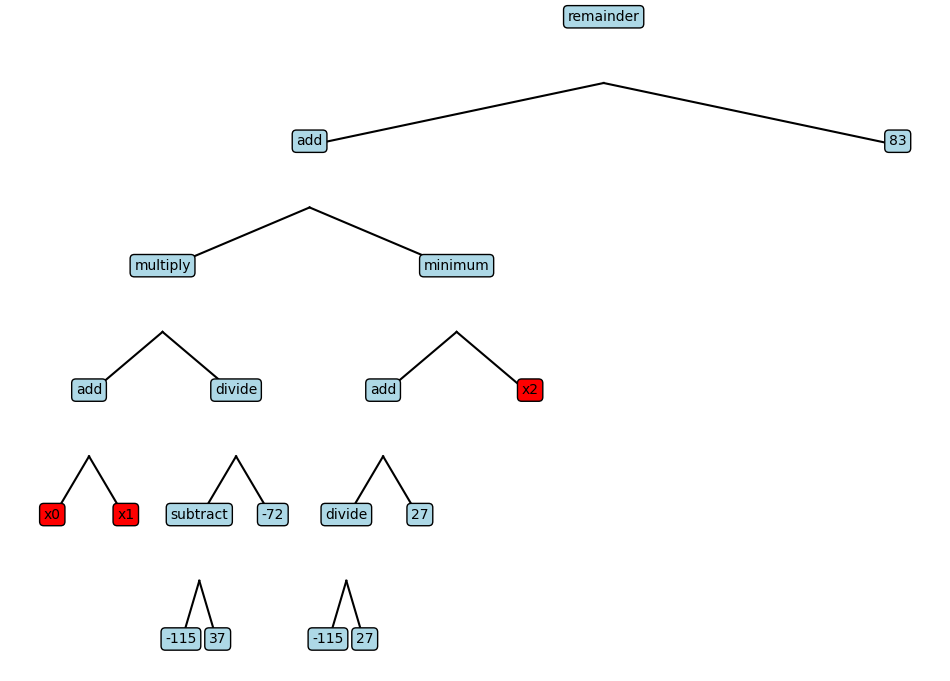

In [10]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_size, max_generations, mutation_rate):
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        
        self.unary_ops = unary_ops
        self.binary_ops = binary_ops

        self.population = [Tree("grow") for _ in range(int(population_size/2))] + [Tree("full") for _ in range(int(population_size/2))]

    

    def select_parents(self):
        return np.random.choice(self.population, 2)
    
    def select_parents_tournament(self):
        tournament_size = 7
        tournament = list(np.random.choice(self.population, tournament_size))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]


    def mutate(self, tree):
        if np.random.rand() < self.mutation_rate:
            if np.random.rand() < 0.5:
                tree.mutate_subtree()
            else:
                tree.mutate_single_node()

    def evolve(self):
        best_tree = None
        best_fitness = np.inf
      
        for generation in tqdm(range(self.max_generations)):
            new_population = []

            for _ in range(int(self.population_size/2)):
                parent1, parent2 = self.select_parents_tournament()
                offspring1,offspring2=Tree.crossover(parent1, parent2)
                offspring1.collapse_branch(offspring1.root)
                offspring2.collapse_branch(offspring2.root)
               
                self.mutate(offspring1)
                self.mutate(offspring2)
       
                new_population.append(offspring1)
                new_population.append(offspring2)

            self.population += new_population
            for tree in self.population:
                tree.compute_fitness()
            generation_fitnesses = [tree.fitness for tree in self.population]
            generation_best_fitness = min(generation_fitnesses)

            if generation_best_fitness < best_fitness:
                best_fitness = generation_best_fitness
                best_tree = self.population[np.argmin(generation_fitnesses)]
            #trim the population to the best population_size
            self.population.sort(key=lambda x: x.fitness)
            self.population = self.population[:self.population_size]
            # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
        return best_tree, best_fitness


TREE_DEPTH = 5
Tree.set_params(unary_ops, binary_ops, 3, 100,TREE_DEPTH, x, y)
regressor = SymbolicRegression(
    population_size=100,
    max_generations=50,
    mutation_rate=0.1,
)


best_tree, best_fitness = regressor.evolve()
print(best_tree.to_np_formula())
print(f"Best Fitness: {best_fitness}")
print("Best Tree:")
best_tree.add_drawing()



# print(x.shape)
# # print(x)
# # print([x[0][0]]+[x[1][0]]+[x[2][0]])
# print(x[2][0])
# print(regressor.population[0].fitness)
# regressor.population[0].print_tree()
# print(regressor.population[0].evaluate_tree([x[0][0]]+[x[1][0]]+[x[2][0]]))
# print(regressor.population[0].evaluate_tree(x[:,0]))
# print("Best Tree:")
# best_tree.print_tree()
# print(f"Best Fitness: {best_fitness}")
